<a href="https://colab.research.google.com/github/Andres54ml/ME02_especializacion/blob/main/EDA_PROYECTO/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Descarga de datos históricos de Bancolombia ADR (CIB)

En esta celda se utiliza la librería `yfinance` para descargar el historial de precios de apertura del ADR de Bancolombia (símbolo "CIB") desde el 11 de mayo de 2015 hasta el 9 de mayo de 2025. Luego, se filtra únicamente la columna **Open** (precio de apertura) y se reinicia el índice para que la columna de fechas quede como una columna regular del DataFrame.



In [ ]:
import yfinance as yf

# Descarga histórico de Bancolombia ADR (CIB)
df_principal = yf.download(
    "CIB",
    start="2015-05-11",
    end="2025-05-9"
)

# Filtrar solo la columna Open y mover el índice Date a columna
df_principal = df_principal[['Open']].reset_index()

print(df_principal.head())

[*********************100%***********************]  1 of 1 completed

Price        Date       Open
Ticker                   CIB
0      2015-05-11  22.255101
1      2015-05-12  22.114086
2      2015-05-13  22.293996
3      2015-05-14  22.396113
4      2015-05-15  22.279406


## Carga y procesamiento de datos externos

En esta celda se carga un archivo de Excel que contiene una hoja llamada **"Datos"**. Todos los valores se leen como texto (`dtype=str`). Luego:

1. Se convierte la columna **Fecha** al formato de fecha (`datetime`), especificando que el día viene primero (formato DD/MM/YYYY).
2. Finalmente, se renombra la columna **Fecha** a **Date** para mantener consistencia con otros DataFrames.

In [ ]:
import pandas as pd

# Lee las dos hojas como texto
archivo = "/content/graficador_series (1) (1).xlsx"
sheets = pd.read_excel(
    archivo,
    sheet_name=["Datos"],
    dtype=str
)

df_secundario =  sheets["Datos"]

# 1) Convertir a datetime, indicando dayfirst para DD/MM/YYYY
df_secundario['Fecha'] = pd.to_datetime(
    df_secundario['Fecha'],
    format="%d/%m/%Y",
    dayfirst=True,
    errors="raise"
)

# 2) (Opcional) Si además quieres renombrar la columna a 'Date'
df_secundario.rename(columns={'Fecha': 'Date'}, inplace=True)

## Unificación de columnas y combinación de DataFrames

- Se renombran las columnas del DataFrame `df_principal` uniendo los niveles con guiones bajos (`_`) en caso de que existan múltiples niveles (MultiIndex).
- Luego se asegura que el índice esté reseteado (aunque ya se hizo anteriormente).
- Se imprime el número de niveles de columnas tanto para `df_principal` como para `df_secundario`.
- Finalmente, se realiza un *merge* (unión) entre `df_principal` y `df_secundario` usando la columna **Date** como clave. Se usa una unión tipo *left join*, conservando todos los registros de `df_principal` y anexando los de `df_secundario` cuando coincidan las fechas.

In [ ]:
# Por ejemplo, unir con guión bajo los niveles que haya
df_principal.columns = [
    "_".join(filter(None, col)).strip()
    for col in df_principal.columns.values
]

df_principal = df_principal.reset_index()

# print("Niveles de columnas en principal:", df_principal.columns.nlevels)
# print("Niveles de columnas en secundario:", df_secundario.columns.nlevels)

df_merged = df_principal.merge(
    df_secundario,
    on='Date',
    how='left',
    suffixes=('', '_sec')
)

## Limpieza de datos: manejo de valores faltantes

- Se seleccionan algunas columnas económicas relevantes del DataFrame combinado `df_merged`.
- En esas columnas, se reemplazan los valores "-" por `NaN` para que pandas los reconozca como datos faltantes.
- Finalmente, se imprime la cantidad de valores nulos (`NaN`) en cada una de las columnas seleccionadas, como verificación del reemplazo.


In [ ]:
import numpy as np

cols = [
    "M1, mensual(Dato fin de mes)",
    "Inflación total(Dato fin de mes)",
    "Crecimiento PIB real, Trimestral, base: 2015, Ajuste estacional(Dato fin de trimestre)",
    "Tasa de desempleo - total nacional(Dato fin de mes)"
]

# Reemplaza todos los "-" por NaN solo en esas columnas
df_merged[cols] = df_merged[cols].replace("-", np.nan)

# Comprueba que ahora pandas los reconoce como NaN
print(df_merged[cols].isna().sum())


M1, mensual(Dato fin de mes)                                                              2430
Inflación total(Dato fin de mes)                                                          2429
Crecimiento PIB real, Trimestral, base: 2015, Ajuste estacional(Dato fin de trimestre)    2489
Tasa de desempleo - total nacional(Dato fin de mes)                                       2430
dtype: int64


## Análisis exploratorio de series temporales económicas univariado

Este bloque realiza un análisis exploratorio para cuatro variables macroeconómicas. Para cada serie:

1. **Preprocesamiento**: Se limpia la columna (remueve símbolos, cambia comas por puntos y convierte a numérico) y se convierte a serie temporal.
2. **Estadística descriptiva**: Se imprimen los estadísticos básicos como media, desviación estándar, mínimo, máximo, etc.
3. **Visualizaciones**:
   - Serie temporal.
   - Histograma.
   - Media móvil con ventana adecuada al periodo (mensual o trimestral).
4. **Autocorrelación**: Se grafica la autocorrelación rápida con `pandas`.
5. **Pruebas de estacionariedad**:
   - **ADF (Augmented Dickey-Fuller)** para detectar raíz unitaria.
   - **KPSS (Kwiatkowski-Phillips-Schmidt-Shin)** para detectar estacionariedad alrededor de una media constante.
6. **Descomposición estacional**: Se descompone la serie en tendencia, estacionalidad y residuo.
7. **ACF y PACF**: Se grafican la función de autocorrelación y autocorrelación parcial con un número de rezagos adecuado.

Este análisis ayuda a entender el comportamiento temporal de cada variable y a evaluar si requieren transformaciones antes de ser usadas en modelos.

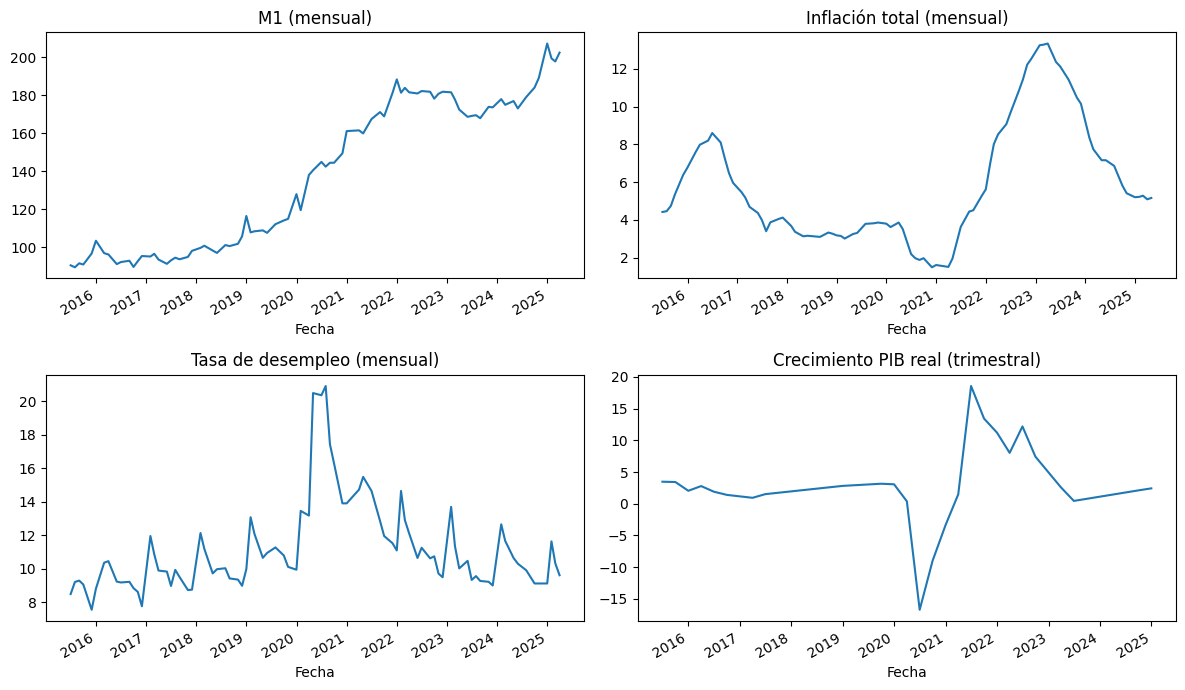

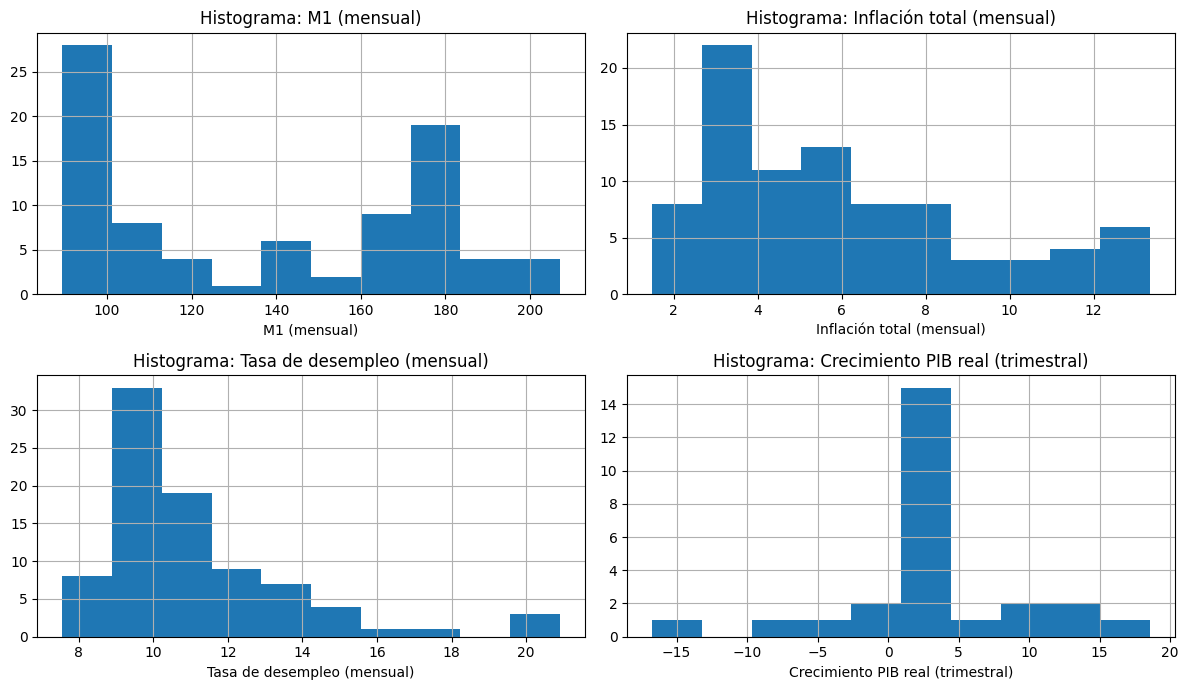

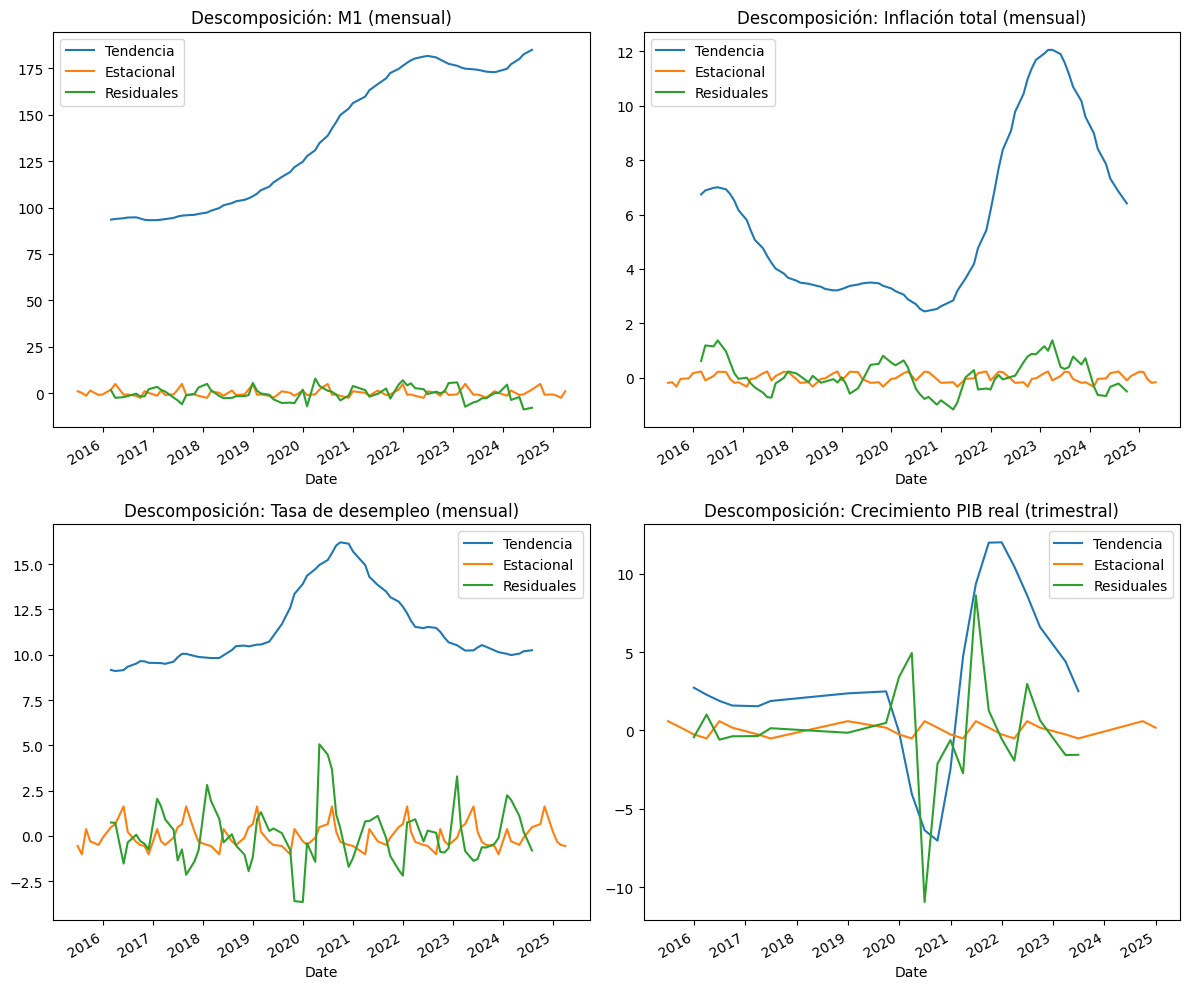


=== Resultados Prueba ADF ===
                            Serie  ADF Statistic  p-value      Conclusión
                     M1 (mensual)         0.0775   0.9645 No estacionaria
        Inflación total (mensual)        -2.9387   0.0410    Estacionaria
      Tasa de desempleo (mensual)        -2.9922   0.0356    Estacionaria
Crecimiento PIB real (trimestral)        -2.2428   0.1911 No estacionaria


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Definimos cada serie con: (columna, título, period, ventana rolling, lags ACF/PACF)
series_info = [
    ("M1, mensual(Dato fin de mes)", "M1 (mensual)", 12),
    ("Inflación total(Dato fin de mes)", "Inflación total (mensual)", 12),
    ("Tasa de desempleo - total nacional(Dato fin de mes)", "Tasa de desempleo (mensual)", 12),
    ("Crecimiento PIB real, Trimestral, base: 2015, Ajuste estacional(Dato fin de trimestre)", "Crecimiento PIB real (trimestral)", 4),
]

series_data = []
adf_results = []

# Extraemos y procesamos cada serie
for col, title, period in series_info:
    df_temp = df_merged[["Date", col]].dropna(subset=[col])
    df_temp["Date"] = pd.to_datetime(df_temp["Date"])
    df_temp.set_index("Date", inplace=True)

    s = (df_temp[col]
         .astype(str)
         .str.replace(",", ".", regex=False)
         .str.replace("%", "", regex=False)
         .astype(float)
         .dropna())

    # Guardamos datos para los gráficos
    series_data.append({'title': title, 'series': s, 'period': period})

    # Prueba ADF
    adf_stat, adf_p, *_ = adfuller(s)
    conclusion = "Estacionaria" if adf_p < 0.05 else "No estacionaria"
    adf_results.append({
        'Serie': title,
        'ADF Statistic': round(adf_stat, 4),
        'p-value': round(adf_p, 4),
        'Conclusión': conclusion
    })

# 1) Gráficas de serie temporal en matriz 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
for ax, data in zip(axes.flatten(), series_data):
    data['series'].plot(ax=ax, title=data['title'])
    ax.set_xlabel("Fecha")
plt.tight_layout()
plt.show()

# 2) Histogramas en matriz 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
for ax, data in zip(axes.flatten(), series_data):
    data['series'].hist(ax=ax)
    ax.set_title(f"Histograma: {data['title']}")
    ax.set_xlabel(data['title'])
plt.tight_layout()
plt.show()

# 3) Descomposición estacional en matriz 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, data in zip(axes.flatten(), series_data):
    decomp = seasonal_decompose(data['series'], model='additive', period=data['period'])
    decomp.trend.plot(ax=ax, label='Tendencia')
    decomp.seasonal.plot(ax=ax, label='Estacional')
    decomp.resid.plot(ax=ax, label='Residuales')
    ax.set_title(f"Descomposición: {data['title']}")
    ax.legend()
plt.tight_layout()
plt.show()

# 4) Tabla de resultados ADF
df_adf = pd.DataFrame(adf_results)
print("\n=== Resultados Prueba ADF ===")
print(df_adf.to_string(index=False))

## Analisis univariado CIB

=== Estadísticos descriptivos de Open_CIB ===
count    2515.000000
mean       21.531204
std         4.931758
min         9.648109
25%        17.889306
50%        20.572258
75%        24.916917
max        41.779999
Name: Open_CIB, dtype: float64 



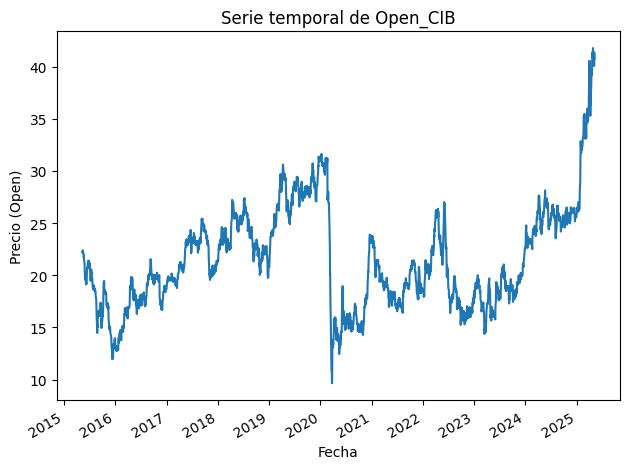

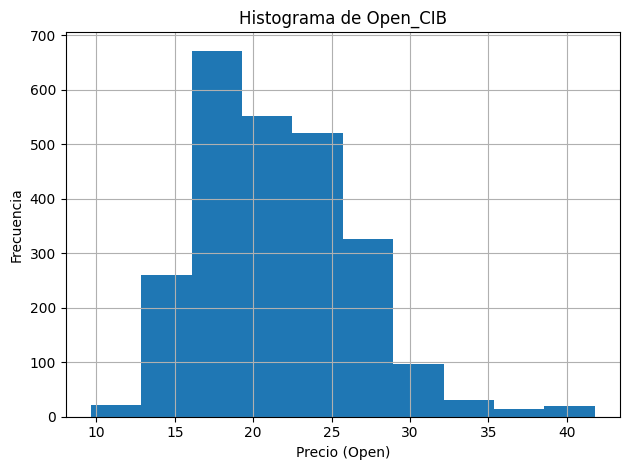

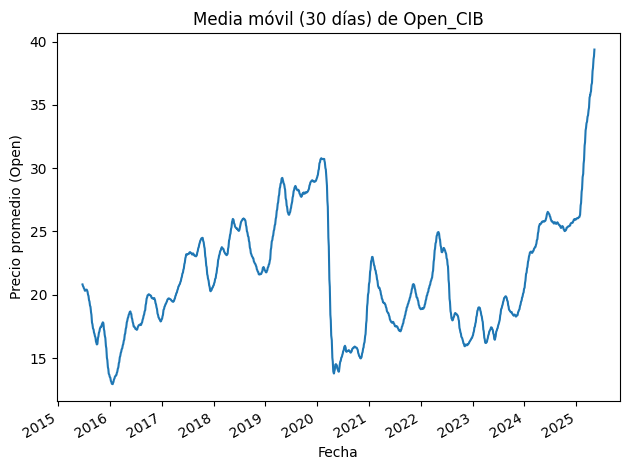

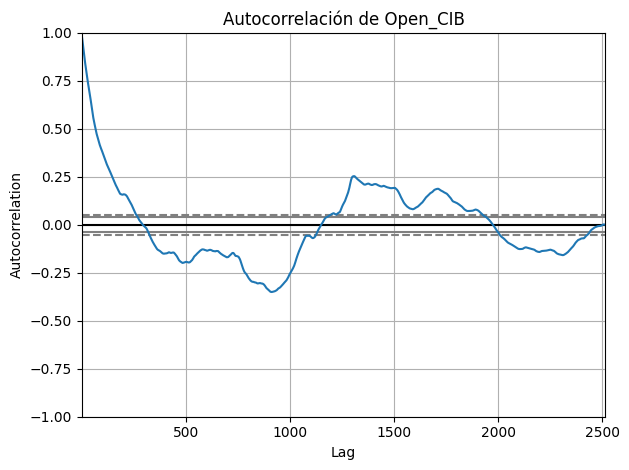

--- Prueba ADF de Open_CIB ---
Estadística ADF: -1.6140  |  p-valor: 0.4759


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

# 1) Prepara el DataFrame: asegúrate de que Date es datetime y ponlo de índice
df = df_merged.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 2) Estadísticos descriptivos básicos
print("=== Estadísticos descriptivos de Open_CIB ===")
print(df['Open_CIB'].describe(), "\n")

# 3) Serie temporal de Open_CIB
plt.figure()
df['Open_CIB'].plot()
plt.title("Serie temporal de Open_CIB")
plt.xlabel("Fecha")
plt.ylabel("Precio (Open)")
plt.tight_layout()
plt.show()

# 4) Histograma de frecuencias
plt.figure()
df['Open_CIB'].hist()
plt.title("Histograma de Open_CIB")
plt.xlabel("Precio (Open)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# 5) Media móvil (rolling mean) de 30 días
plt.figure()
df['Open_CIB'].rolling(window=30).mean().plot()
plt.title("Media móvil (30 días) de Open_CIB")
plt.xlabel("Fecha")
plt.ylabel("Precio promedio (Open)")
plt.tight_layout()
plt.show()

# 6) Autocorrelación
plt.figure()
autocorrelation_plot(df['Open_CIB'])
plt.title("Autocorrelación de Open_CIB")
plt.tight_layout()
plt.show()

# 7) Prueba de estacionariedad ADF
adf_stat, adf_p, _, _, _, _ = adfuller(df['Open_CIB'].dropna())
print("--- Prueba ADF de Open_CIB ---")
print(f"Estadística ADF: {adf_stat:.4f}  |  p-valor: {adf_p:.4f}")


## Preparación y alineación de series temporales para análisis bivariado

Este bloque realiza los siguientes pasos:

1. **Preparar el DataFrame principal**:
   - Si existe columna `Date`, se convierte a índice datetime para facilitar operaciones temporales.
   - Se asegura que el índice sea del tipo `DatetimeIndex`.

2. **Definir variables macroeconómicas** con sus frecuencias (mensual o trimestral) y variables diarias de interés, junto con la columna `Open_CIB` (serie diaria del precio de apertura de la acción).

3. **Limpieza genérica** para convertir las columnas a valores numéricos, eliminando caracteres no numéricos y reemplazando comas por puntos.

4. **Generar DataFrames bivariados**:
   - Para cada variable macroeconómica (mensual o trimestral), se crea un DataFrame que contiene la serie diaria `Open_CIB` alineada (mediante forward-fill) a las fechas de la variable macro.
   - Se filtran las fechas donde ambas series tienen datos válidos.
   - Estos pares se almacenan en un diccionario con una clave descriptiva.

5. **Generar DataFrame para la variable diaria** (Tasa de política monetaria) emparejada con `Open_CIB` solo en las fechas comunes.

6. Finalmente, se imprimen los tamaños de cada DataFrame creado y las claves disponibles en el diccionario para facilitar su acceso posterior.

Este procedimiento facilita el análisis conjunto o modelamiento entre la serie diaria de `Open_CIB` y las variables macroeconómicas en sus respectivas frecuencias.

In [ ]:
import pandas as pd
import numpy as np

# --- 0. Preparar DataFrame ---
# Si tu DataFrame tiene columna 'Date', úsala como índice
if 'Date' in df_merged.columns:
    df_merged['Date'] = pd.to_datetime(df_merged['Date'])
    df_merged.set_index('Date', inplace=True)

# Asegúrate de que el índice sea de tipo datetime
if not isinstance(df_merged.index, pd.DatetimeIndex):
    df_merged.index = pd.to_datetime(df_merged.index)

# Columnas de interés y limpieza inicial
col_open = 'Open_CIB'
macros = {
    'M1, mensual(Dato fin de mes)': 'M',
    'Inflación total(Dato fin de mes)': 'M',
    'Tasa de desempleo - total nacional(Dato fin de mes)': 'M',
    'Crecimiento PIB real, Trimestral, base: 2015, Ajuste estacional(Dato fin de trimestre)': 'Q'
}
diarias = [
    'Tasa de política monetaria(Dato diario)'
]

# --- Limpieza robusta de columnas numéricas ---
def clean_generic(series):
    s = series.astype(str)
    s = s.str.replace(r'[^0-9\.,\-]', '', regex=True)
    s = s.str.replace(',', '.', regex=False)
    return pd.to_numeric(s, errors='coerce')

for col in [col_open] + list(macros.keys()) + diarias:
    if col in df_merged.columns:
        df_merged[col] = clean_generic(df_merged[col])

# Diccionario para almacenar DataFrames por par
dict_pair_dfs = {}

# --- 1. Preparar la serie diaria de Open_CIB ---
open_daily = df_merged[col_open].dropna()

# --- 2. Generar DataFrames para variables mensuales y trimestrales ---
for col_macro, freq in macros.items():
    macro_series = df_merged[col_macro].dropna()
    # Alinear Open_CIB a fechas macro con forward-fill
    open_aligned = open_daily.reindex(macro_series.index, method='ffill')
    # Filtrar solo valores válidos en ambas series
    mask = open_aligned.notna() & macro_series.notna()
    df_pair = pd.DataFrame({
        'Date': open_aligned.index[mask],
        col_open: open_aligned[mask].values,
        col_macro: macro_series[mask].values
    })
    key = f"{col_open}_vs_{col_macro}"
    dict_pair_dfs[key] = df_pair
    print(f"DataFrame '{key}' creado con {len(df_pair)} observaciones.")

# --- 3. Generar DataFrame para variable diaria ---
# Solo Tasa de política monetaria
col_daily = diarias[0]
daily_series = df_merged[col_daily].dropna()
common_idx = open_daily.index.intersection(daily_series.index)
open_matched = open_daily.reindex(common_idx)
daily_matched = daily_series.reindex(common_idx)
df_pol = pd.DataFrame({
    'Date': common_idx,
    col_open: open_matched.values,
    col_daily: daily_matched.values
})
key_pol = f"{col_open}_vs_{col_daily}"
dict_pair_dfs[key_pol] = df_pol
print(f"DataFrame '{key_pol}' creado con {len(df_pol)} observaciones.")

# --- 4. Mostrar claves disponibles ---
print("\nClaves en dict_pair_dfs:", list(dict_pair_dfs.keys()))

DataFrame 'Open_CIB_vs_M1, mensual(Dato fin de mes)' creado con 85 observaciones.
DataFrame 'Open_CIB_vs_Inflación total(Dato fin de mes)' creado con 86 observaciones.
DataFrame 'Open_CIB_vs_Tasa de desempleo - total nacional(Dato fin de mes)' creado con 85 observaciones.
DataFrame 'Open_CIB_vs_Crecimiento PIB real, Trimestral, base: 2015, Ajuste estacional(Dato fin de trimestre)' creado con 26 observaciones.
DataFrame 'Open_CIB_vs_Tasa de política monetaria(Dato diario)' creado con 2514 observaciones.

Claves en dict_pair_dfs: ['Open_CIB_vs_M1, mensual(Dato fin de mes)', 'Open_CIB_vs_Inflación total(Dato fin de mes)', 'Open_CIB_vs_Tasa de desempleo - total nacional(Dato fin de mes)', 'Open_CIB_vs_Crecimiento PIB real, Trimestral, base: 2015, Ajuste estacional(Dato fin de trimestre)', 'Open_CIB_vs_Tasa de política monetaria(Dato diario)']


## Análisis de correlaciones entre pares de series temporales

Este código realiza lo siguiente:

1. Define un diccionario de nombres cortos para variables, facilitando la visualización.

2. Implementa la función `analizar_correlaciones` que:
   - Itera sobre cada DataFrame en el diccionario de pares de series (`dict_pair_dfs`).
   - Limpia los datos y asegura que cada DataFrame tenga dos columnas (las dos series a comparar).
   - Calcula la correlación de Pearson y su p-valor entre las dos series.
   - Clasifica la relación como:
     - **Procíclica** si la correlación es significativamente positiva (mayor que un umbral).
     - **Contracíclica** si es significativamente negativa.
     - **Acíclica** si la correlación es cercana a cero.
   - Grafica ambas series en el tiempo usando dos ejes Y, con títulos que muestran la correlación y clasificación.

3. Ejecuta el análisis sobre el diccionario de pares generado previamente.

4. Muestra en consola un resumen con los valores de correlación, p-valores y clasificación de cada par.

Esta función permite explorar visual y numéricamente las relaciones entre la serie diaria del precio de apertura `Open_CIB` y las variables macroeconómicas asociadas, ayudando a identificar patrones cíclicos o anticíclicos.


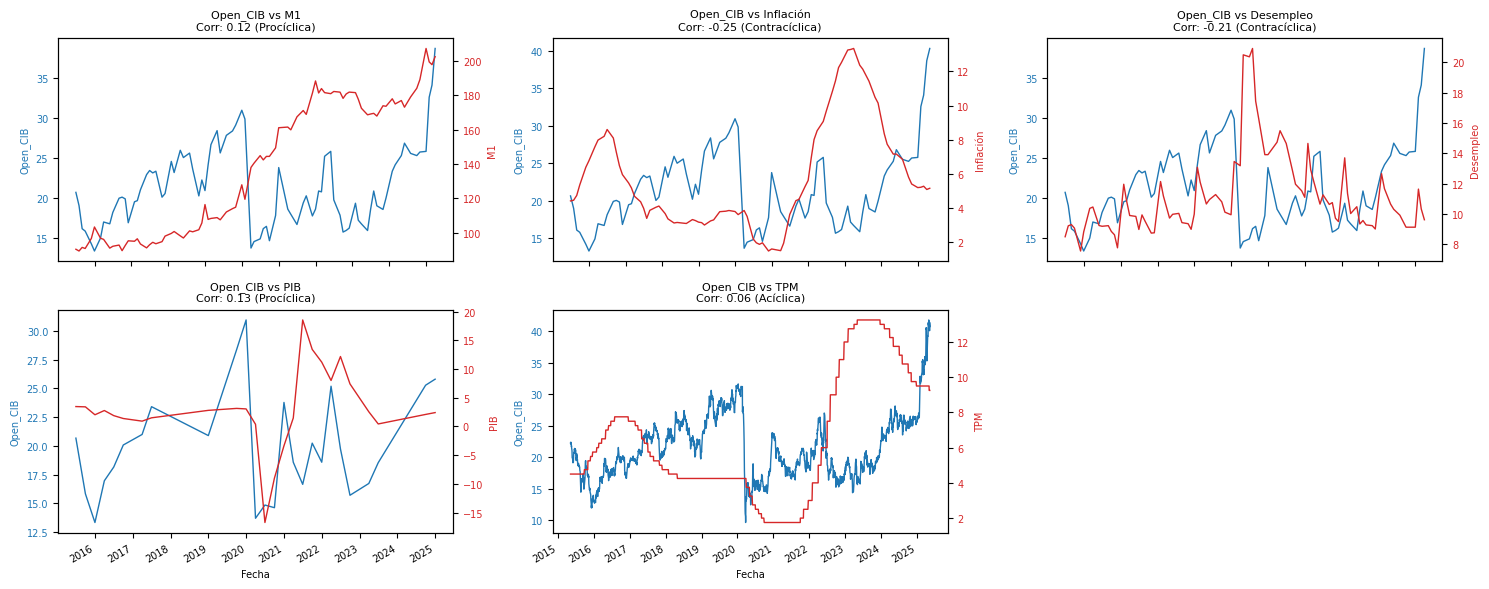


=== Resumen de Correlaciones (Tabla) ===
| Serie 1 | Serie 2 | Correlación | p-valor | Tipo |
|----------|-----------|-------------|---------|---------------|
| Open_CIB | M1        | 0.116       | 0.2886  | Procíclica    |
| Open_CIB | Inflación | -0.245      | 0.0228  | Contracíclica |
| Open_CIB | Desempleo | -0.205      | 0.0596  | Contracíclica |
| Open_CIB | PIB       | 0.133       | 0.5169  | Procíclica    |
| Open_CIB | TPM       | 0.061       | 0.0022  | Acíclica      |
----------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Necesitamos numpy para calcular el tamaño de la matriz de subplots
from scipy.stats import pearsonr
import pandas as pd # Aseguramos la importación de pandas

# Diccionario de nombres cortos para variables
nombre_corto = {
    'M1, mensual(Dato fin de mes)': 'M1',
    'Inflación total(Dato fin de mes)': 'Inflación',
    'Tasa de desempleo - total nacional(Dato fin de mes)': 'Desempleo',
    'Crecimiento PIB real, Trimestral, base: 2015, Ajuste estacional(Dato fin de trimestre)': 'PIB',
    'Tasa de política monetaria(Dato diario)': 'TPM',
    'Open_CIB': 'Open_CIB'
}

def analizar_correlaciones_y_graficar(df_dict, corr_lim=0.1):
    """
    Analiza correlaciones entre pares de series en un diccionario de DataFrames
    y prepara los datos para gráficos y tabla resumen.

    Args:
        df_dict (dict): Diccionario donde las claves son nombres de pares
                        y los valores son DataFrames con 'Date' y 2 columnas de series.
        corr_lim (float): Límite para clasificar la correlación como procíclica/contracíclica.

    Returns:
        list: Lista de tuplas con los resultados de correlación (var1_corto, var2_corto, corr, pval, tipo).
        list: Lista de tuplas con datos de gráficos (var1_corto, var2_corto, corr, tipo, df_con_datos).
              df_con_datos incluye el índice y las dos series originales (sin dropna si es posible,
              pero la correlación se calcula en dropna).
    """
    resumen_correlaciones = []
    datos_graficos = []

    # Contar cuántos pares serán realmente graficados (pasan las validaciones)
    num_plots = 0
    for key, df in df_dict.items():
         if len(df) >= 2 and df.shape[1] == 3 and 'Date' in df.columns: # Shape 3 por Date + 2 series
             num_plots += 1

    # --- Preparar la matriz de subplots ANTES del bucle ---
    # Calcular el número de filas y columnas para la matriz
    n_cols = int(np.ceil(np.sqrt(num_plots)))
    n_rows = int(np.ceil(num_plots / n_cols))

    # Si no hay plots, evitamos crear la figura
    if num_plots > 0:
        # Ajustar figsize según el número de plots, podrías necesitar ajustar esto manualmente
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3)) # Ajusta figsize
        # Aplanar el array de ejes para iterar fácilmente
        axes = axes.flatten()
    else:
        fig, axes = None, None # No crear figura si no hay plots
        print("No hay pares de series válidos para graficar.")


    plot_index = 0 # Índice para seguir qué subplot estamos usando

    # --- Bucle principal para analizar y recoger datos ---
    for key, df in df_dict.items():
        # Validaciones (igual que en el código original)
        if len(df) < 2:
             continue
        if df.shape[1] != 3 or 'Date' not in df.columns: # Esperamos Date + 2 columnas de series
             print(f"Saltando par '{key}': Formato incorrecto. Esperado 3 columnas (Date + 2 series), encontrado {df.shape[1]}.")
             continue

        # Hacer una copia para evitar modificar el df original si se usa dropna
        df_pair = df.copy()

        # Separar Date y las series
        df_pair = df_pair.set_index('Date')
        var1, var2 = df_pair.columns
        serie1_raw = df_pair[var1]
        serie2_raw = df_pair[var2]

        # Calcular correlación solo en datos no nulos alineados
        # Alinear las series en sus índices de fecha y dropear NaNs para la correlación
        aligned_df = pd.concat([serie1_raw, serie2_raw], axis=1).dropna()

        # Asegurarse de que todavía hay suficientes datos para correlación después de dropna
        if len(aligned_df) < 2:
            print(f"Saltando par '{key}': Menos de 2 puntos de datos no nulos alineados.")
            continue

        serie1_aligned = aligned_df[var1]
        serie2_aligned = aligned_df[var2]


        # Cálculo de correlación
        try:
            corr, pval = pearsonr(serie1_aligned, serie2_aligned)
        except ValueError: # pearsonr puede fallar si los datos son constantes o tienen problemas
             print(f"No se pudo calcular la correlación para '{key}'. Posiblemente datos constantes o insuficientes después de dropna.")
             corr, pval = np.nan, np.nan # Asignar NaN si falla
             tipo = "Error"
        except Exception as e:
             print(f"Error inesperado al calcular correlación para '{key}': {e}")
             corr, pval = np.nan, np.nan # Asignar NaN si falla
             tipo = "Error"


        # Clasificación (solo si la correlación se calculó)
        if not np.isnan(corr):
            if corr > corr_lim:
                tipo = "Procíclica"
            elif corr < -corr_lim:
                tipo = "Contracíclica"
            else:
                tipo = "Acíclica"


        # Añadir a la lista de resultados de correlación
        resumen_correlaciones.append((nombre_corto.get(var1, var1), nombre_corto.get(var2, var2), corr, pval, tipo))

        # Añadir datos a la lista de gráficos
        # Usamos las series originales sin dropna para graficar, para mostrar los huecos
        # La correlación mostrada en el título es la calculada con dropna
        datos_graficos.append((nombre_corto.get(var1, var1), nombre_corto.get(var2, var2), corr, tipo, df_pair)) # Pasamos el df_pair con Date index

        # --- Graficar en el subplot actual ---
        # Solo si se crearon axes (es decir, num_plots > 0)
        if axes is not None and plot_index < len(axes):
            ax1 = axes[plot_index]
            color1, color2 = 'tab:blue', 'tab:red'

            # Títulos y etiquetas usando nombres cortos
            ax1.set_title(f"{nombre_corto.get(var1, var1)} vs {nombre_corto.get(var2, var2)}\nCorr: {corr:.2f} ({tipo})", fontsize=8) # Ajusta fontsize
            ax1.set_xlabel('Fecha', fontsize=7) # Ajusta fontsize
            ax1.set_ylabel(nombre_corto.get(var1, var1), color=color1, fontsize=7) # Ajusta fontsize
            ax1.plot(df_pair.index, serie1_raw, color=color1, linewidth=1) # Ajusta linewidth
            ax1.tick_params(axis='y', labelcolor=color1, labelsize=7) # Ajusta labelsize
            ax1.tick_params(axis='x', labelsize=7, rotation=45) # Ajusta labelsize y rota fechas

            ax2 = ax1.twinx()
            ax2.set_ylabel(nombre_corto.get(var2, var2), color=color2, fontsize=7) # Ajusta fontsize
            ax2.plot(df_pair.index, serie2_raw, color=color2, linewidth=1) # Ajusta linewidth
            ax2.tick_params(axis='y', labelcolor=color2, labelsize=7) # Ajusta labelsize

            # Mejorar el formato de la fecha en el eje x (opcional pero recomendado)
            fig.autofmt_xdate() # Ajusta las etiquetas de fecha automáticamente

            plot_index += 1 # Mover al siguiente subplot

    # --- Después del bucle: Mostrar gráficos y generar tabla ---

    # Ocultar cualquier subplot no utilizado
    if axes is not None:
        for i in range(plot_index, len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout() # Ajustar el diseño para evitar superposiciones
        plt.show() # Mostrar la figura con todos los subplots


    return resumen_correlaciones

resultados_correlaciones = analizar_correlaciones_y_graficar(dict_pair_dfs)

# --- Mostrar resumen de correlaciones en formato de tabla ---
print("\n=== Resumen de Correlaciones (Tabla) ===")

if not resultados_correlaciones:
    print("No hay resultados de correlación para mostrar.")
else:
    # Encabezados de la tabla
    headers = ["Serie 1", "Serie 2", "Correlación", "p-valor", "Tipo"]

    # Crear las filas de la tabla
    table_rows = []
    for var1, var2, corr, pval, tipo in resultados_correlaciones:
        # Formatear valores numéricos
        corr_str = f"{corr:.3f}" if not np.isnan(corr) else "NaN"
        pval_str = f"{pval:.4f}" if not np.isnan(pval) else "NaN"

        table_rows.append([var1, var2, corr_str, pval_str, tipo])

    # Calcular el ancho máximo de cada columna para un mejor formato (opcional pero útil)
    col_widths = [len(h) for h in headers]
    for row in table_rows:
        for i, item in enumerate(row):
            col_widths[i] = max(col_widths[i], len(str(item)))

    # Imprimir encabezado
    header_line = "| " + " | ".join(headers) + " |"
    print(header_line)

    # Imprimir línea separadora
    separator_line = "|-" + "-|-".join(['-' * width for width in col_widths]) + "-|"
    # Ajustar separador para que coincida con el ancho calculado (más preciso)
    separator_line_refined = "|-" + "-|-".join(['-' * (max(len(headers[i]), col_widths[i])) for i in range(len(headers))]) + "-|"
    print(separator_line_refined) # Usar el separador ajustado

    # Imprimir filas de datos
    for row in table_rows:
        # Alinear cada elemento de la fila según el ancho calculado
        formatted_row = [str(item).ljust(col_widths[i]) for i, item in enumerate(row)]
        print("| " + " | ".join(formatted_row) + " |")

    print("-" * len(header_line)) # Línea final para cerrar la tabla (opcional)


